In [ ]:
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms, models
from torchinfo import summary
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.ops as ops
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import logging
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [48]:
## constants
BATCH_SIZE = 32
NUM_EPOCHS = 1
NUM_WORKERS = 0
SEED = 123
IMAGES_DIR = '../Data/raw/images'
MASKS_DIR = '../Data/raw/masks'
METADATA_PATH = '../Data/raw/metadata.csv'
AUGMENTED_METADATA_PATH = '../Data/processed/augmentation/augmented_metadata.csv'

In [49]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [50]:
def get_processed_images_and_masks():
    metadata = pd.read_csv(METADATA_PATH)
    images = [os.path.join(IMAGES_DIR, img) for img in metadata['Image']]
    masks = [os.path.join(MASKS_DIR, mask) for mask in metadata['Mask']]
    return images, masks

In [51]:
images, masks = get_processed_images_and_masks()
data = pd.DataFrame({'Image': images, 'Mask': masks})

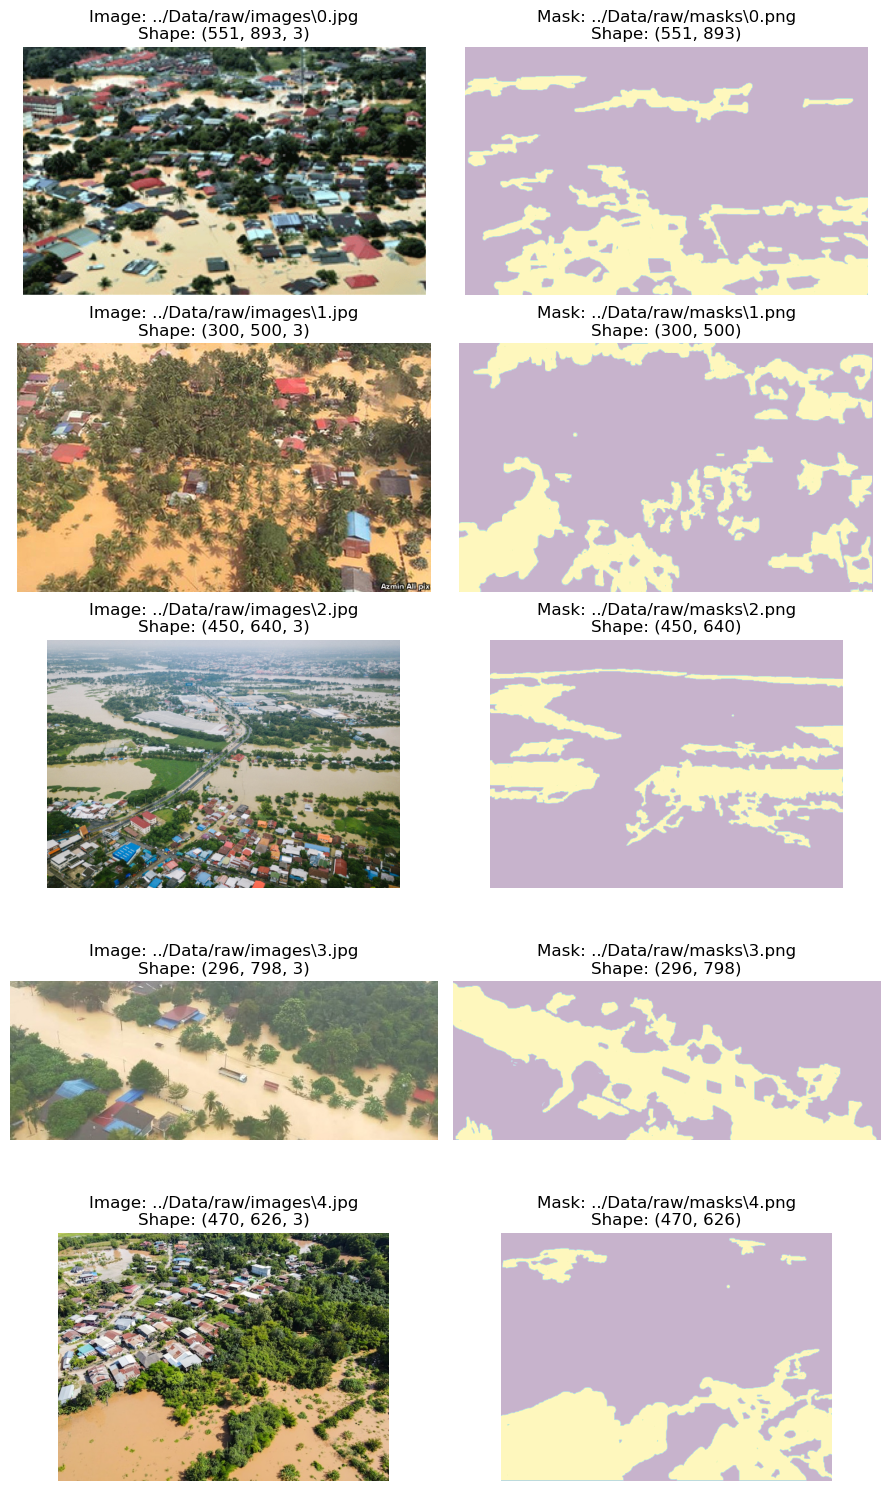

In [52]:
NUM_IMAGES = 10

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(9, 15))
ax = ax.flat

for index, row in data.iterrows():
    if index >= (NUM_IMAGES / 2):
        break

    img = Image.open(row.iloc[0]).convert("RGB")
    mk = Image.open(row.iloc[1])
    
    ax[index * 2].imshow(img)
    ax[index * 2].set_title(f'Image: {row.iloc[0]}\nShape: {np.array(img).shape}')
    ax[index * 2].axis('off')
    
    ax[index * 2 + 1].imshow(mk, alpha=0.3)
    ax[index * 2 + 1].set_title(f'Mask: {row.iloc[1]}\nShape: {np.array(mk).shape}')
    ax[index * 2 + 1].axis('off')

fig.tight_layout()
plt.show()

In [53]:
data_train, data_rest = train_test_split(data, test_size=0.3, random_state=SEED)
data_val, data_test = train_test_split(data_rest, test_size=0.5, random_state=SEED)

In [54]:
data_train.shape, data_val.shape, data_test.shape

((203, 2), (43, 2), (44, 2))

In [55]:
def custom_mask_transform(mask):
    mask = np.array(mask)
    mask = cv2.resize(mask, dsize=(224, 224), interpolation=cv2.INTER_NEAREST)
    
    # Apply connected component analysis to merge connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    
    # Create a new mask with all connected components treated as one object
    new_mask = np.zeros_like(mask)
    for i in range(1, num_labels):  # Start from 1 to exclude the background
        new_mask[labels == i] = 255
    
    return torch.tensor(new_mask, dtype=torch.uint8)

In [56]:
class FloodDataset(Dataset):
    def __init__(self, data: pd.DataFrame, image_transforms: transforms, mask_transforms: transforms):
        self.data = data
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_path = self.data.iloc[idx, 0]
        image = Image.open(image_path).convert("RGB")
        image = self.image_transforms(image)
        
        mask_path = self.data.iloc[idx, 1]
        mask = Image.open(mask_path)
        mask = self.mask_transforms(mask)
        
        # Convert mask to binary and generate bounding boxes and labels
        mask_np = np.array(mask)
        obj_ids = np.unique(mask_np)[1:]  # Exclude background
        masks = mask_np == obj_ids[:, None, None]
        boxes = []
        for mask in masks:
            pos = np.where(mask)
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            if xmin < xmax and ymin < ymax:
                boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(obj_ids),), dtype=torch.int64)  # Assuming binary classification
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        target = {'boxes': boxes, 'labels': labels, 'masks': masks}
        
        return image, target

In [57]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [58]:
class MaskRCNNModel(nn.Module):
    def __init__(self, num_classes):
        super(MaskRCNNModel, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.get_model_instance_segmentation(num_classes)
        self.model.to(self.device)

    def get_model_instance_segmentation(self, num_classes):
        # Load a pre-trained model for classification and return only the features
        backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        backbone = nn.Sequential(*(list(backbone.children())[:-2]))
        backbone.out_channels = 2048

        # RPN (Region Proposal Network) anchor generator
        rpn_anchor_generator = AnchorGenerator(
            sizes=((32, 64, 128, 256, 512),),
            aspect_ratios=((0.5, 1.0, 2.0),) * 5)

        # Feature maps to be used for the ROI align operation
        roi_pooler = ops.MultiScaleRoIAlign(
            featmap_names=['0'], output_size=7, sampling_ratio=2)

        mask_roi_pooler = ops.MultiScaleRoIAlign(
            featmap_names=['0'], output_size=14, sampling_ratio=2)

        # Put the pieces together inside a MaskRCNN model
        model = MaskRCNN(backbone,
                         num_classes=num_classes,
                         rpn_anchor_generator=rpn_anchor_generator,
                         box_roi_pool=roi_pooler,
                         mask_roi_pool=mask_roi_pooler)

        return model

    def forward(self, images, targets=None):
        if targets:
            return self.model(images, targets)
        return self.model(images)

    def train_model(self, train_loader, val_loader, optimizer, num_epochs=10):
        self.model.train()
        for epoch in range(num_epochs):
            logging.info(f'Starting epoch {epoch + 1}/{num_epochs}')
            i = 0
            for images, targets in train_loader:
                images = list(image.to(self.device) for image in images)
                targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
                loss_dict = self.model(images, targets)
                losses = sum(loss for loss in loss_dict.values())

                optimizer.zero_grad()
                losses.backward()
                optimizer.step()

                i += 1
                if i % 10 == 0:
                    logging.info(f"Epoch: {epoch + 1}, Iteration: {i}, Loss: {losses.item()}")

            # Evaluate on the validation set at the end of each epoch
            val_f1 = self.evaluate(val_loader)
            logging.info(f"Epoch {epoch + 1} validation F1 score: {val_f1}")

    def evaluate(self, data_loader):
        self.model.eval()
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for images, targets in data_loader:
                images = list(image.to(self.device) for image in images)
                outputs = self.model(images)
                
                for i, output in enumerate(outputs):
                    pred_masks = output['masks'].cpu().numpy()
                    pred_masks = (pred_masks > 0.5).astype(np.uint8)  # Binarize the masks
                    true_masks = targets[i]['masks'].cpu().numpy()
                    all_preds.extend(pred_masks)
                    all_targets.extend(true_masks)
                    
        all_preds = np.concatenate(all_preds, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)
        
        f1 = f1_score(all_targets.flatten(), all_preds.flatten(), average='binary')
        return f1

    def visualize_predictions(self, data_loader, num_images=10):
        self.model.eval()
        images_shown = 0
        with torch.no_grad():
            for images, targets in data_loader:
                images = list(image.to(self.device) for image in images)
                outputs = self.model(images)
                
                for i in range(len(images)):
                    if images_shown >= num_images:
                        return
                    
                    img = images[i].permute(1, 2, 0).cpu().numpy()
                    true_mask = targets[i]['masks'].cpu().numpy()
                    pred_mask = outputs[i]['masks'].cpu().numpy()
                    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Binarize the masks
                    
                    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
                    ax[0].imshow(img)
                    ax[0].set_title("Image")
                    ax[0].axis('off')

                    ax[1].imshow(true_mask[0], cmap='gray')
                    ax[1].set_title("True Mask")
                    ax[1].axis('off')
                    
                    ax[2].imshow(pred_mask[0, 0], cmap='gray')
                    ax[2].set_title("Predicted Mask")
                    ax[2].axis('off')

                    plt.show()
                    images_shown += 1

In [59]:
images, masks = get_processed_images_and_masks()

In [60]:
## preparing for resnet50
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

preprocess_mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [61]:
train_dataset = FloodDataset(data_train, transform, custom_mask_transform)

In [62]:
val_dataset = FloodDataset(data_val, transform, custom_mask_transform)

In [63]:
train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=8, 
                              shuffle=True, 
                              num_workers=0, 
                              collate_fn=collate_fn)

val_dataloader = DataLoader(dataset=val_dataset, 
                            batch_size=8, 
                            shuffle=False, 
                            num_workers=0, 
                            collate_fn=collate_fn)

In [64]:
def validate_bounding_boxes(data, mask_transforms):
    for idx in range(len(data)):
        mask_path = data.iloc[idx, 1]
        mask = Image.open(mask_path)
        mask_np_original = np.array(mask)
        
        mask = mask_transforms(mask)
        mask_np = np.array(mask)
        
        obj_ids = np.unique(mask_np)[1:]  # Exclude background
        masks = mask_np == obj_ids[:, None, None]
        
        for i, mask in enumerate(masks):
            pos = np.where(mask)
            if len(pos[0]) == 0 or len(pos[1]) == 0:
                continue  # Skip empty masks
            
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            if xmin >= xmax or ymin >= ymax:
                print(f"Invalid bounding box found: [{xmin}, {ymin}, {xmax}, {ymax}] for mask at index {idx}")
                
                # Print unique values in the original and transformed masks
                print(f"Unique values in the original mask at index {idx}: {np.unique(mask_np_original)}")
                print(f"Unique values in the transformed mask at index {idx}: {np.unique(mask_np)}")
                
                # Plot original mask and transformed mask side by side
                fig, ax = plt.subplots(1, 3, figsize=(18, 6))
                ax[0].imshow(mask_np_original, cmap='gray')
                ax[0].set_title(f"Original Mask at index {idx}")
                ax[0].axis('off')

                ax[1].imshow(mask_np, cmap='gray')
                ax[1].set_title(f"Transformed Mask at index {idx}")
                ax[1].axis('off')
                
                # Plot the specific mask causing the issue
                ax[2].imshow(mask, cmap='gray')
                ax[2].set_title(f"Problematic Mask at index {idx}, object {i}")
                ax[2].axis('off')
                
                plt.show()

                print(f"DataFrame entry for index {idx}:")
                print(data.iloc[idx])
                return  # Stop after the first invalid mask

# Validate bounding boxes before training
validate_bounding_boxes(data, custom_mask_transform)


In [65]:
# Let's visualize a batch
batch_images, batch_targets = next(iter(train_dataloader))

batch_images_shapes = [img.shape for img in batch_images]
batch_masks_shapes = [target['masks'].shape for target in batch_targets]

print("Batch Images Shapes:", batch_images_shapes)
print("Batch Masks Shapes:", batch_masks_shapes)

Batch Images Shapes: [torch.Size([3, 224, 224]), torch.Size([3, 224, 224]), torch.Size([3, 224, 224]), torch.Size([3, 224, 224]), torch.Size([3, 224, 224]), torch.Size([3, 224, 224]), torch.Size([3, 224, 224]), torch.Size([3, 224, 224])]
Batch Masks Shapes: [torch.Size([1, 224, 224]), torch.Size([1, 224, 224]), torch.Size([1, 224, 224]), torch.Size([1, 224, 224]), torch.Size([1, 224, 224]), torch.Size([1, 224, 224]), torch.Size([1, 224, 224]), torch.Size([1, 224, 224])]


In [66]:
model = MaskRCNNModel(num_classes=2)

In [67]:
class WrapperModel(nn.Module):
    def __init__(self, model):
        super(WrapperModel, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model([x])

wrapper_model = WrapperModel(model.model)

summary(wrapper_model, 
        input_size=(3, 224, 224), 
        col_width=15, 
        col_names=['input_size', 'output_size', 'num_params', 'trainable'], 
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape     Output Shape    Param #         Trainable
WrapperModel (WrapperModel)                        [3, 224, 224]   [100, 4]        --              True
├─MaskRCNN (model)                                 [3, 224, 224]   [100, 4]        --              True
│    └─GeneralizedRCNNTransform (transform)        [3, 224, 224]   [1, 3, 800, 800] --              --
│    └─Sequential (backbone)                       [1, 3, 800, 800] [1, 2048, 25, 25] --              True
│    │    └─Conv2d (0)                             [1, 3, 800, 800] [1, 64, 400, 400] 9,408           True
│    │    └─BatchNorm2d (1)                        [1, 64, 400, 400] [1, 64, 400, 400] 128             True
│    │    └─ReLU (2)                               [1, 64, 400, 400] [1, 64, 400, 400] --              --
│    │    └─MaxPool2d (3)                          [1, 64, 400, 400] [1, 64, 200, 200] --              --
│    │    └─Sequential (4)                    

In [68]:
params = [p for p in model.model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

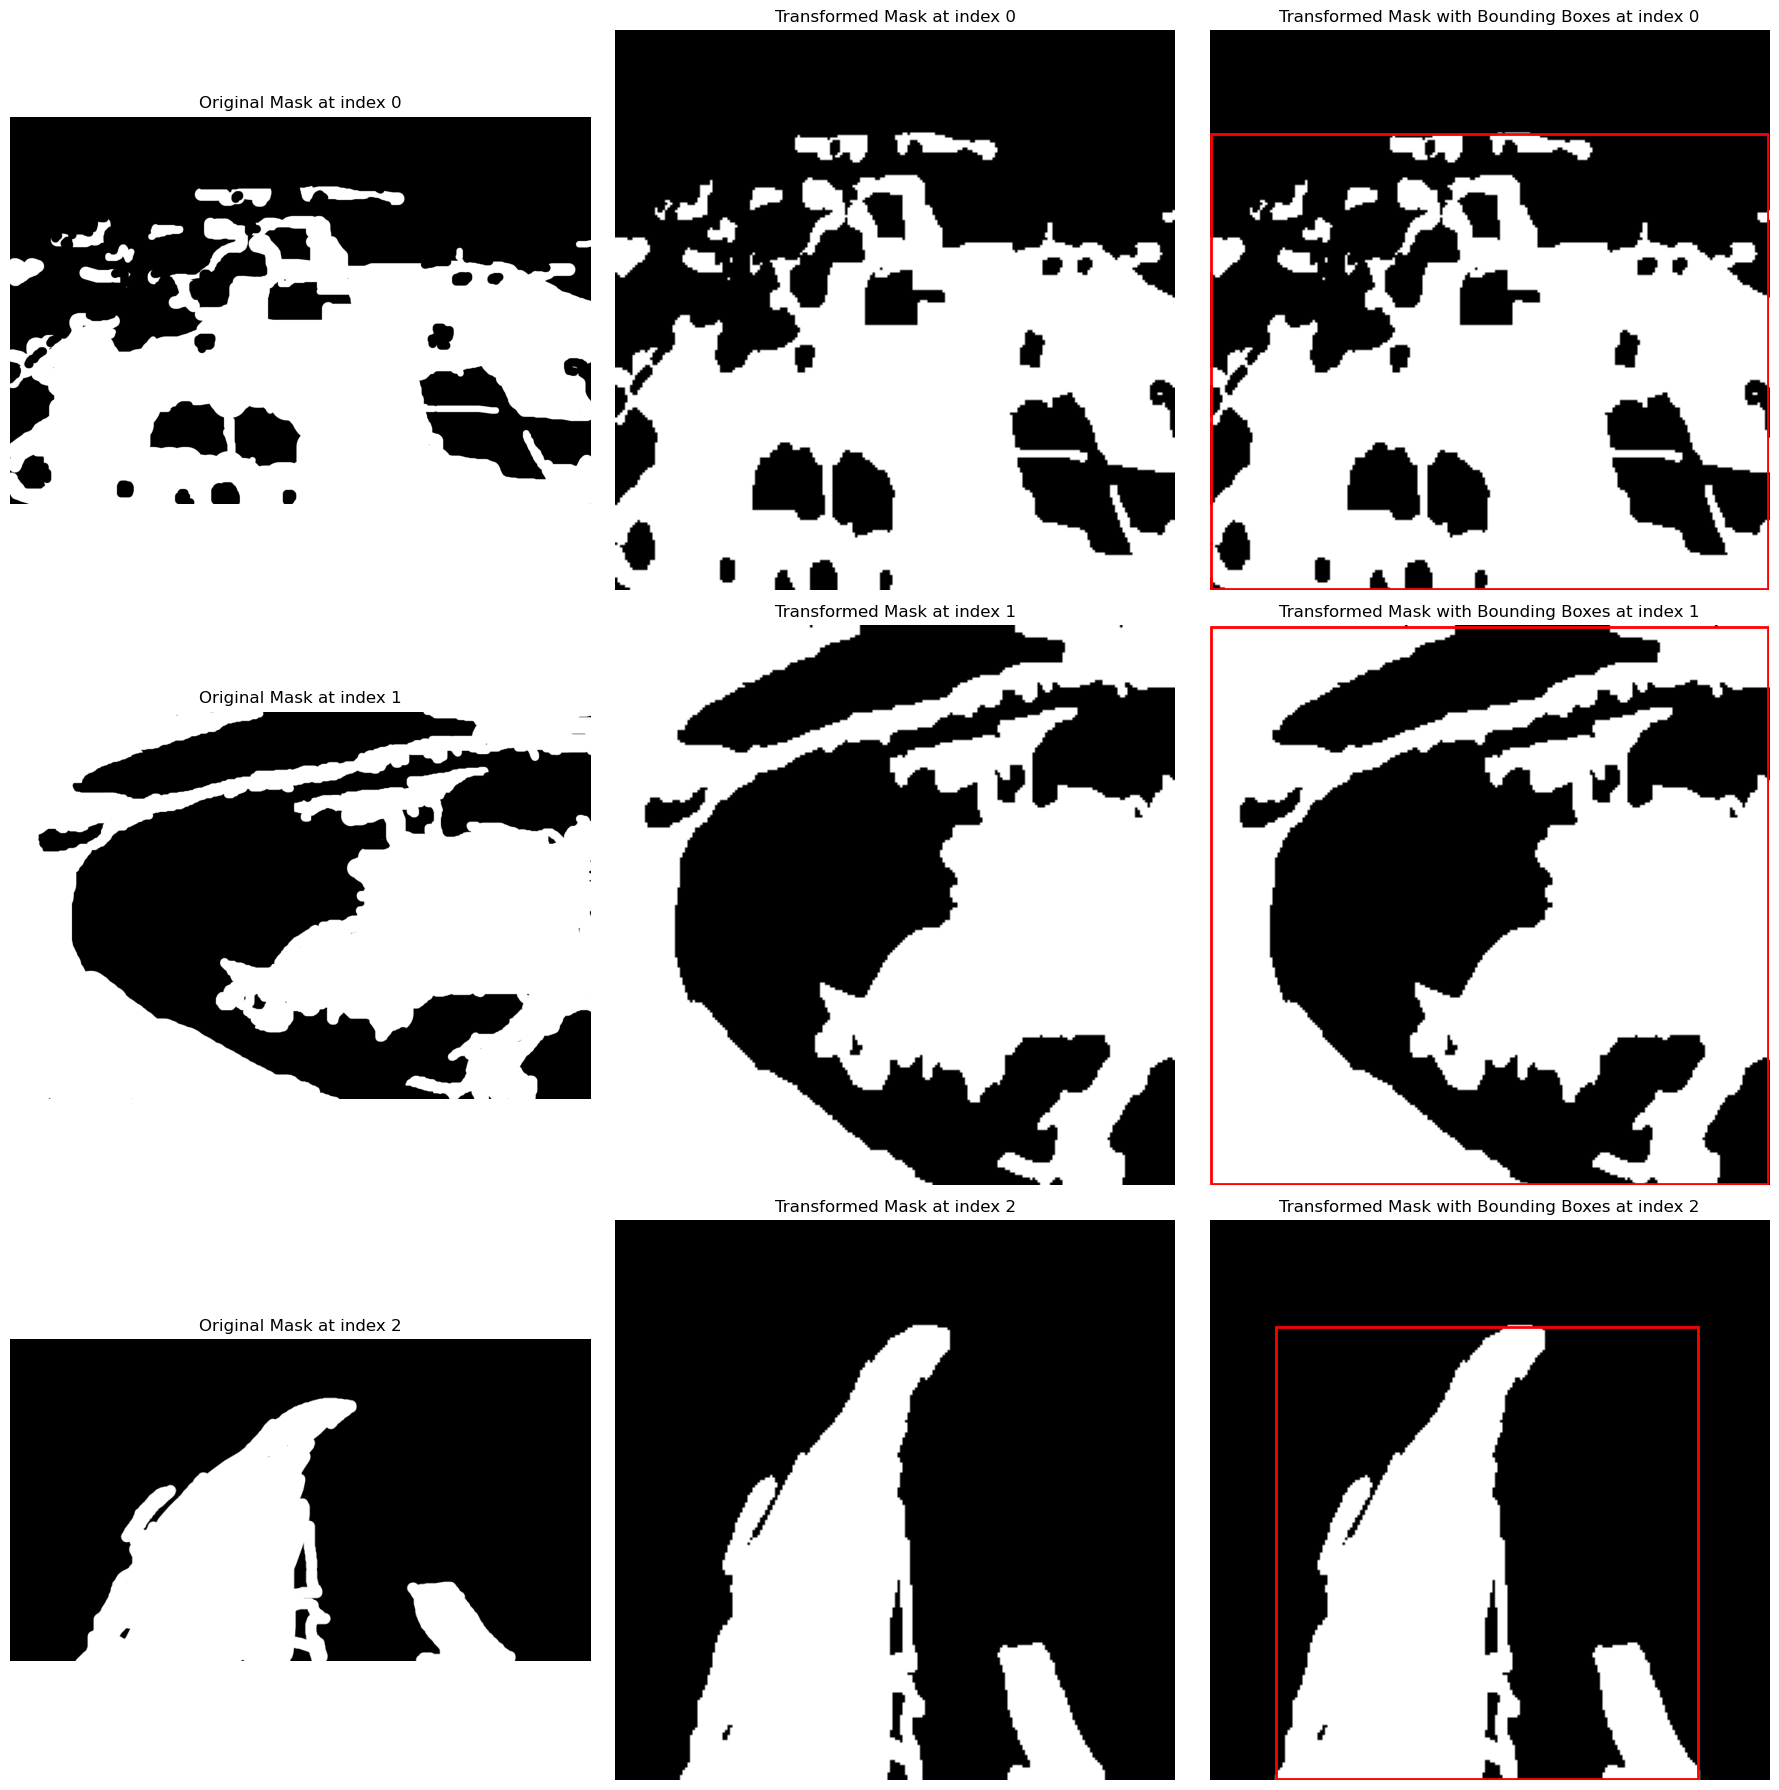

In [71]:
def plot_masks_with_bounding_boxes(data, mask_transforms, num_masks=3):
    fig, ax = plt.subplots(num_masks, 3, figsize=(18, 6 * num_masks))

    for idx in range(num_masks):
        mask_path = data.iloc[idx, 1]
        mask = Image.open(mask_path)
        mask_np_original = np.array(mask)
        
        mask = mask_transforms(mask)
        mask_np = np.array(mask)
        
        obj_ids = np.unique(mask_np)[1:]  # Exclude background
        masks = mask_np == obj_ids[:, None, None]
        boxes = []
        
        for mask in masks:
            pos = np.where(mask)
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            if xmin < xmax and ymin < ymax:
                boxes.append([xmin, ymin, xmax, ymax])
        
        ax[idx, 0].imshow(mask_np_original, cmap='gray')
        ax[idx, 0].set_title(f'Original Mask at index {idx}')
        ax[idx, 0].axis('off')

        ax[idx, 1].imshow(mask_np, cmap='gray')
        ax[idx, 1].set_title(f'Transformed Mask at index {idx}')
        ax[idx, 1].axis('off')

        ax[idx, 2].imshow(mask_np, cmap='gray')
        for box in boxes:
            rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax[idx, 2].add_patch(rect)
        ax[idx, 2].set_title(f'Transformed Mask with Bounding Boxes at index {idx}')
        ax[idx, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Use the function to plot 3 masks with bounding boxes
plot_masks_with_bounding_boxes(data_train, custom_mask_transform, num_masks=3)

In [69]:
model.train_model(train_dataloader, val_dataloader, optimizer, num_epochs=1)

2024-07-06 17:05:57,892 - INFO - Starting epoch 1/1


KeyboardInterrupt: 

In [ ]:
val_f1 = model.evaluate(val_dataloader)
print(f"Final validation F1 score: {val_f1}")

In [ ]:
model.visualize_predictions(val_dataloader, num_images=10)